<a href="https://colab.research.google.com/github/jdanifalcon/sig-bigdata-python-covid19/blob/main/Visualizacion_COVID_Tabasco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualización de datos abiertos de COVID-19 en México

* Jessica Daniela O. Falcón (Estudiante, Twitter: [@jdanielafalcon](https://twitter.com/jdanielafalcon)
)

En esta actividad de capacitación, se manejo Python junto con [la base de datos abiertos](https://www.gob.mx/salud/documentos/datos-abiertos-152127) que publica diariamente la Dirección General de Epidemiología de la Secretaría de Salud.

La base de datos es grande y tiene varias complejidades que se fueron revisando. El objetivo es utilizar este recurso de información y que, al hacerlo, se desarrollen gráficas y mapas utilizando librerías de Python.

Los pasos están organizados de la siguiente forma:

* Instalación de dependencias
* Descarga de datos y exploración del contenido
* *Aplanado* de los datos
* Agregados diarios (casos, defunciones)
* Gráficas
* Mapas

Realizado durante la semana de capacitación "Escuela de Verano CentroGeo 2021"
Impartido por el:
[Laboratorio Nacional de Geointeligencia](http://www.geoint.mx/)

* Pablo López-Ramírez (CentroGeo, Twitter: [@oskrsasi](https://twitter.com/oskrsasi)
)
* Oscar Sánchez-Siordia (CentroGeo, Twitter: [@plablo09](https://twitter.com/plablo09))

## Instalación de dependencias

La mayor parte del taller utilizaremos principalmente la librería [Pandas](https://pandas.pydata.org/) para el análisis de datos, esta librería viene incluida en el stack que nos provee automáticamente COlab. Sin embargo, para poder leer datos geográficos y hacer mapas, vamos a necesitar instalar [Geopandas](https://geopandas.org/), que es una extensión de Pandas para el manejo de datos geográficos, y un par de librerías más para hacer mapas interactivos. 

La instalación de dependencias en Colab es relativamente sencilla, el caso de Geopandas tiene elguna complicación porque requiere de la instalación de un par de librerías del sistema (es decir, librerías que no son sólo de Python). La siguiente celda contiene las instrucciones (al sistema operativo debajo de Colab, noten el símbolo `!` al inicio de cada instrucción) para instalar todas las dependencias que necesitamos.

In [1]:
%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
!pip install mapclassify

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (1,578 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../python3-numpy_

Ahora vamos a importar de una vez todas las dependencias que vamos a usar en el resto del notebook

In [2]:
import os
import glob
import itertools
from pathlib import Path
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import timedelta, date, datetime
import csv
import openpyxl
import requests
import plotly.express as px
import mapclassify
import folium

import logging

## Descargar datos

El primer paso es, evidentemente, descargar los datos. Es claro que podríamos ir a la [página](https://www.gob.mx/salud/documentos/datos-abiertos-152127) de la Dirección General de Epidemiología (DGE) y descargarlos, sin embargo, lo vamos a hacer por el camino difícil de bajarlos usando Python.

Para eso, vamos a definir una función que tome como argumento la fecha para la que queremos descargar los datos y el *path* en donde los vamos a guardar. La función es relativamente simple, sólo hace un *request* al archivo histórico de la DGE y guarda los datos en la ruta configurada.

Para trabajar vamos siempre a descargar tres archivos:

* Los datos COVID-19 
* El catálogo de campos
* El archivo de descripción

El primer archivo contiene la serie de tiempo de seguimiento de casos hasta la fecha configurada, los dos archivos restantes sirven para entender la información contenida en los datos.

Entonces, primero definimos la función

In [3]:
def bajar_datos_salud(directorio_datos='/content/', fecha='05-05-2021'):
    '''
        Descarga el archivo de datos y los diccionarios para la fecha solicitada.
    '''
    fecha = datetime.strptime(fecha, "%d-%m-%Y")
    url_salud_historicos = 'http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/historicos/'    
    archivo_nombre = f'{fecha.strftime("%y%m%d")}COVID19MEXICO.csv.zip'
    archivo_ruta = os.path.join(directorio_datos, archivo_nombre)
    url_diccionario = 'http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/diccionario_datos_covid19.zip'
    diccionario_ruta = os.path.join(directorio_datos, 'diccionario.zip')
    if os.path.exists(archivo_ruta):
        logging.debug(f'Ya existe {archivo_nombre}')
    else:
        print(f'Bajando datos {fecha.strftime("%d.%m.%Y")}')
        url_dia = "{}/{}/datos_abiertos_covid19_{}.zip".format(fecha.strftime('%Y'),
                                                                fecha.strftime('%m'),
                                                                fecha.strftime('%d.%m.%Y'))
        url = url_salud_historicos + url_dia
        r = requests.get(url, allow_redirects=True)
        open(archivo_ruta, 'wb').write(r.content)
        r = requests.get(url_diccionario, allow_redirects=True)
        open(diccionario_ruta, 'wb').write(r.content)
        with zipfile.ZipFile(diccionario_ruta, 'r') as zip_ref:
          zip_ref.extractall(directorio_datos)

Con la función que acabamos de definir, podemos bajar los datos hasta la última fecha disponible

In [4]:
ayer = datetime.now() - timedelta(1)
bajar_datos_salud(fecha=ayer.strftime('%d-%m-%Y'))

Bajando datos 13.07.2021


## Exploración del contenido

Antes de empezar a manipular los datos, lo primero que tenemos que hacer es explorarlos brevemente y entender cómo están guardados. Leamos los datos en un DataFrame.

Fíjense en la ruta en donde la función de arriba descarga los datos, con la barra exploradora del lado izquierdo pueden navegar hasta esa ruta y copiar el *path*

In [5]:
df = pd.read_csv('/content/210713COVID19MEXICO.csv.zip', dtype=object, encoding='latin-1')
df

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2021-07-13,z482b8,2,12,09,2,09,09,012,1,2020-10-16,2020-10-16,9999-99-99,97,2,41,1,97,99,99,2,2,2,2,2,2,2,2,2,2,2,2,97,2,97,1,99,MÃ©xico,97,97
1,2021-07-13,z49a69,1,12,23,1,23,23,004,2,2020-07-20,2020-07-17,2020-07-21,1,1,66,1,2,2,2,1,2,2,2,1,2,2,1,2,2,1,2,97,2,97,2,99,MÃ©xico,97,1
2,2021-07-13,z23d9d,1,12,22,2,24,22,009,1,2021-01-05,2021-01-05,9999-99-99,97,2,29,1,97,2,2,2,2,2,2,2,2,2,98,2,2,2,2,97,2,97,6,99,MÃ©xico,97,97
3,2021-07-13,z24953,1,12,09,1,09,09,010,1,2020-10-15,2020-10-15,9999-99-99,97,2,40,1,98,99,99,2,2,2,2,2,2,2,2,2,2,1,1,2,2,97,7,99,MÃ©xico,97,97
4,2021-07-13,zz8e77,2,12,09,2,09,09,002,1,2020-04-16,2020-04-10,9999-99-99,97,2,34,1,97,2,2,2,1,1,2,2,2,2,2,2,2,2,2,97,2,97,6,99,MÃ©xico,97,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7784990,2021-07-13,c7d79c,1,4,12,1,12,12,001,1,2021-07-12,2021-07-11,9999-99-99,97,2,33,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,97,2,97,6,99,MÃ©xico,97,97
7784991,2021-07-13,613e86,2,4,01,1,01,01,001,1,2021-07-12,2021-07-08,9999-99-99,97,2,37,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,97,1,2,7,99,MÃ©xico,97,97
7784992,2021-07-13,e681ec,2,4,19,1,19,19,026,1,2021-07-13,2021-07-13,9999-99-99,97,2,30,1,2,2,2,98,98,98,98,98,98,98,98,98,98,2,2,97,1,1,3,99,MÃ©xico,97,97
7784993,2021-07-13,4d8255,2,4,09,1,09,09,002,1,2021-07-11,2021-07-10,9999-99-99,97,2,32,1,2,2,2,98,98,98,98,98,98,98,98,98,98,2,2,97,1,1,3,99,MÃ©xico,97,97


Cada renglón en la base de datos corresponde a un caso en *seguimiento*, el resultado de cada caso se puede actualizar en sucesivas publicaciones de la base de datos. Las columnas describen un conjunto de variables asociadas al seguimiento de cada uno de los casos. Las dos primeras columnas corresponden a la fecha en la que se actualizó el caso y a un id único para cada caso respectivamente, en este taller no vamos a usar esas dos columnas.

Luego vienen un conjunto de columnas que describen la unidad médica de reporte y, después, las columnas que nos interesan más, que son las que describen al paciente.

Para entender un poco mejor los datos, conviene leer el archívo de catálogo. Pueden descargarlo en el explorador de archivos del lado izquierdo, pero aquí vamos a abrirlo y explorarlo un poco con Pandas. Como el catálogo es un archivo de excel con varias hojas, lo vamos a leer usando [openpyxl]() que nos va a devolver un diccionario de DataFrames que relacionan el nombre de la hoja con los datos que contiene.

In [7]:
catalogos = '/content/201128 Catalogos.xlsx'
nombres_catalogos = ['Catálogo de ENTIDADES', # Acá están los nombres de las hojas del excel
                      'Catálogo MUNICIPIOS',
                      'Catálogo SI_NO',
                      'Catálogo TIPO_PACIENTE',
                      'Catálogo CLASIFICACION_FINAL',
                      'Catálogo RESULTADO_LAB'
                     ]
dict_catalogos = pd.read_excel(catalogos,
                          nombres_catalogos,
                          dtype=str,
                          engine='openpyxl')
clasificacion_final = dict_catalogos['Catálogo CLASIFICACION_FINAL']
clasificacion_final.columns = ["CLAVE", "CLASIFICACIÓN", "DESCRIPCIÓN"] # Aquí le damos nombre a las columnas porque en el excel se saltan dos líneas
clasificacion_final

,CLAVE,CLASIFICACIÓN,DESCRIPCIÓN
0,NaN,NaN,NaN
1,CLAVE,CLASIFICACIÓN,DESCRIPCIÓN
2,1,CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍ...,Confirmado por asociación aplica cuando el cas...
3,2,CASO DE COVID-19 CONFIRMADO POR COMITÉ DE DIC...,Confirmado por dictaminación solo aplica para ...
4,3,CASO DE SARS-COV-2 CONFIRMADO,Confirmado aplica cuando:\nEl caso tiene muest...
5,4,INVÁLIDO POR LABORATORIO,Inválido aplica cuando el caso no tienen asoci...
6,5,NO REALIZADO POR LABORATORIO,No realizado aplica cuando el caso no tienen a...
7,6,CASO SOSPECHOSO,Sospechoso aplica cuando: \nEl caso no tienen ...
8,7,NEGATIVO A SARS-COV-2,Negativo aplica cuando el caso:\n1. Se le tomo...


Lo que estamos viendo aquí es el catálogo de datos de la columna `CLASIFICACION_FINAL`. Este catálogo relaciona el valor de la `CLAVE` con su significado. En particular, la columna `CLASIFICACION_FINAL` es la que nos permite identificar los casos positivos como veremos más adelante.

El resto de los catálogos funciona de la misma forma, aunque en este taller sólo trabajaremos con los datos de la clasificación de los pacientes


## *Aplanado* de los datos

Como ya vimos, la información viene codificada, entonces para utilizarla con más facilidad, nos conviene *aplanar* la codificación utilizando los valores que vienen en los catálogos y descriptores de datos.

Para eso vamos a utilizar dos funciones, una que carga los datos que acabamos de bajar y llena los campos a partir de la información que viene en los catálogos y descriptores y otra que simplemente procesa las fechas para tenerlas en un formato más amistoso.

La función también toma un argumento opcional para seleccionar una entidad en específico. En este caso siempre vamos a seleccionar alguna entidad, ya que la base completa es demasiado grande para procesarla en Colab. Noten cómo la selección de la entidad se hace sobre la entidad de residencia del paciente (campo `ENTIDAD_RES`), esto quiere decir que, para cada estado sólo estamos tomando los pacientes que residen en el.

In [17]:
def carga_datos_covid19_MX(fecha='210505', resolver_claves='si_no_binarias', entidad='27'):
    """
        Lee en un DataFrame el CSV con el reporte de casos de la Secretaría de Salud de México publicado en una fecha dada. Esta función
        también lee el diccionario de datos que acompaña a estas publicaciones para preparar algunos campos, en particular permite la funcionalidad
        de generar columnas binarias para datos con valores 'SI', 'No'.

        **Nota**: En esta versión la ruta esta y nombre de los archivos es fija. Asumimos que existe un directorio '/content/'
        donde se encuentran todos los archivos.

        **Nota 2**: Por las actualizaciones a los formatos de datos, esta función sólo va a servir para archivos posteriores a 20-11-28

        resolver_claves: 'sustitucion', 'agregar', 'si_no_binarias', 'solo_localidades'. Resuelve los valores del conjunto de datos usando el
        diccionario de datos y los catálogos. 'sustitucion' remplaza los valores en las columnas, 'agregar'
        crea nuevas columnas. 'si_no_binarias' cambia valores SI, NO, No Aplica, SE IGNORA, NO ESPECIFICADO por 1, 0, 0, 0, 0 respectivamente.

    """
    fecha_formato = '201128'
    nuevo_formato = True
    fecha_carga = pd.to_datetime(fecha, yearfirst=True)
    if fecha_carga < datetime.strptime('20-11-28', "%y-%m-%d"):
      raise ValueError('La fecha debe ser posterior a 20-11-28.')
    
    catalogos=f'/content/{fecha_formato} Catalogos.xlsx'
    descriptores=f'/content/{fecha_formato} Descriptores.xlsx'    
    data_file = os.path.join('/content/', f'{fecha}COVID19MEXICO.csv.zip')
    df = pd.read_csv(data_file, dtype=object, encoding='latin-1')
    if entidad is not None:
      df = df[df['ENTIDAD_RES'] == entidad]
    # Hay un error y el campo OTRA_COMP es OTRAS_COMP según los descriptores
    df.rename(columns={'OTRA_COM': 'OTRAS_COM'}, inplace=True)
    # Asignar clave única a municipios
    df['MUNICIPIO_RES'] = df['ENTIDAD_RES'] + df['MUNICIPIO_RES']
    df['CLAVE_MUNICIPIO_RES'] = df['MUNICIPIO_RES']
    # Leer catalogos
    nombres_catalogos = ['Catálogo de ENTIDADES',
                         'Catálogo MUNICIPIOS',
                         'Catálogo RESULTADO',
                         'Catálogo SI_NO',
                         'Catálogo TIPO_PACIENTE']
    if nuevo_formato:
        nombres_catalogos.append('Catálogo CLASIFICACION_FINAL')
        nombres_catalogos[2] = 'Catálogo RESULTADO_LAB'

    dict_catalogos = pd.read_excel(catalogos,
                              nombres_catalogos,
                              dtype=str,
                              engine='openpyxl')

    entidades = dict_catalogos[nombres_catalogos[0]]
    municipios = dict_catalogos[nombres_catalogos[1]]
    tipo_resultado = dict_catalogos[nombres_catalogos[2]]
    cat_si_no = dict_catalogos[nombres_catalogos[3]]
    cat_tipo_pac = dict_catalogos[nombres_catalogos[4]]
    # Arreglar los catálogos que tienen mal las primeras líneas
    dict_catalogos[nombres_catalogos[2]].columns = ["CLAVE", "DESCRIPCIÓN"]
    dict_catalogos[nombres_catalogos[5]].columns = ["CLAVE", "CLASIFICACIÓN", "DESCRIPCIÓN"]

    if nuevo_formato:
        clasificacion_final = dict_catalogos[nombres_catalogos[5]]


    # Resolver códigos de entidad federal
    cols_entidad = ['ENTIDAD_RES', 'ENTIDAD_UM', 'ENTIDAD_NAC']
    df['CLAVE_ENTIDAD_RES'] = df['ENTIDAD_RES']
    df[cols_entidad] = df[cols_entidad].replace(to_replace=entidades['CLAVE_ENTIDAD'].values,
                                               value=entidades['ENTIDAD_FEDERATIVA'].values)

    # Construye clave unica de municipios de catálogo para resolver nombres de municipio
    municipios['CLAVE_MUNICIPIO'] = municipios['CLAVE_ENTIDAD'] + municipios['CLAVE_MUNICIPIO']

    # Resolver códigos de municipio
    municipios_dict = dict(zip(municipios['CLAVE_MUNICIPIO'], municipios['MUNICIPIO']))
    df['MUNICIPIO_RES'] = df['MUNICIPIO_RES'].map(municipios_dict.get)

    # Resolver resultados
    if nuevo_formato:
        df.rename(columns={'RESULTADO_LAB': 'RESULTADO'}, inplace=True)
        tipo_resultado['DESCRIPCIÓN'].replace({'POSITIVO A SARS-COV-2': 'Positivo SARS-CoV-2'}, inplace=True)

    tipo_resultado = dict(zip(tipo_resultado['CLAVE'], tipo_resultado['DESCRIPCIÓN']))
    df['RESULTADO'] = df['RESULTADO'].map(tipo_resultado.get)
    clasificacion_final = dict(zip(clasificacion_final['CLAVE'], clasificacion_final['CLASIFICACIÓN']))
    df['CLASIFICACION_FINAL'] = df['CLASIFICACION_FINAL'].map(clasificacion_final.get)
    # Resolver datos SI - NO

    # Necesitamos encontrar todos los campos que tienen este tipo de dato y eso
    # viene en los descriptores, en el campo FORMATO_O_FUENTE
    descriptores = pd.read_excel('/content/201128 Descriptores_.xlsx',
                                 index_col='Nº',
                                 engine='openpyxl')
    descriptores.columns = list(map(lambda col: col.replace(' ', '_'), descriptores.columns))
    descriptores['FORMATO_O_FUENTE'] = descriptores.FORMATO_O_FUENTE.str.strip()

    datos_si_no = descriptores.query('FORMATO_O_FUENTE == "CATÁLOGO: SI_ NO"')
    cat_si_no['DESCRIPCIÓN'] = cat_si_no['DESCRIPCIÓN'].str.strip()

    campos_si_no = datos_si_no.NOMBRE_DE_VARIABLE
    nuevos_campos_si_no = campos_si_no

    if resolver_claves == 'agregar':
        nuevos_campos_si_no = [nombre_var + '_NOM' for nombre_var in campos_si_no]
    elif resolver_claves == 'si_no_binarias':
        nuevos_campos_si_no = [nombre_var + '_BIN' for nombre_var in campos_si_no]
        cat_si_no['DESCRIPCIÓN'] = list(map(lambda val: 1 if val == 'SI' else 0, cat_si_no['DESCRIPCIÓN']))

    df[nuevos_campos_si_no] = df[datos_si_no.NOMBRE_DE_VARIABLE].replace(
                                                to_replace=cat_si_no['CLAVE'].values,
                                                value=cat_si_no['DESCRIPCIÓN'].values)

    # Resolver tipos de paciente
    cat_tipo_pac = dict(zip(cat_tipo_pac['CLAVE'], cat_tipo_pac['DESCRIPCIÓN']))
    df['TIPO_PACIENTE'] = df['TIPO_PACIENTE'].map(cat_tipo_pac.get)

    df = procesa_fechas(df)

    return df

def procesa_fechas(covid_df):
    df = covid_df.copy()

    df['FECHA_INGRESO'] = pd.to_datetime(df['FECHA_INGRESO'])
    df['FECHA_SINTOMAS'] = pd.to_datetime(df['FECHA_SINTOMAS'])
    df['FECHA_DEF'] = pd.to_datetime(df['FECHA_DEF'], 'coerce')
    df['DEFUNCION'] = (df['FECHA_DEF'].notna()).astype(int)
    df['EDAD'] = df['EDAD'].astype(int)

    df.set_index('FECHA_INGRESO', drop=False, inplace=True)
    df['AÑO_INGRESO'] = df.index.year
    df['MES_INGRESO'] = df.index.month
    df['DIA_SEMANA_INGRESO'] = df.index.weekday
    df['SEMANA_AÑO_INGRESO'] = df.index.week
    df['DIA_MES_INGRESO'] = df.index.day
    df['DIA_AÑO_INGRESO'] = df.index.dayofyear

    return df

In [18]:
aplanados = carga_datos_covid19_MX(fecha=ayer.strftime('%y%m%d'), entidad='27')
aplanados

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRAS_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,CLAVE_MUNICIPIO_RES,CLAVE_ENTIDAD_RES,INTUBADO_BIN,NEUMONIA_BIN,EMBARAZO_BIN,HABLA_LENGUA_INDIG_BIN,INDIGENA_BIN,DIABETES_BIN,EPOC_BIN,ASMA_BIN,INMUSUPR_BIN,HIPERTENSION_BIN,OTRAS_COM_BIN,CARDIOVASCULAR_BIN,OBESIDAD_BIN,RENAL_CRONICA_BIN,TABAQUISMO_BIN,OTRO_CASO_BIN,TOMA_MUESTRA_LAB_BIN,TOMA_MUESTRA_ANTIGENO_BIN,MIGRANTE_BIN,UCI_BIN,DEFUNCION,AÑO_INGRESO,MES_INGRESO,DIA_SEMANA_INGRESO,SEMANA_AÑO_INGRESO,DIA_MES_INGRESO,DIA_AÑO_INGRESO
FECHA_INGRESO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-06-01,2021-07-13,z3d8f0,1,12,TABASCO,2,TABASCO,TABASCO,BALANCÁN,AMBULATORIO,2020-06-01,2020-05-26,NaT,97,2,15,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,2,NO APLICA (CASO SIN MUESTRA),2,97,CASO SOSPECHOSO,99,MÃ©xico,97,97,27001,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2020,6,0,23,1,153
2020-05-06,2021-07-13,z2540f,1,12,TABASCO,2,TABASCO,TABASCO,CÁRDENAS,HOSPITALIZADO,2020-05-06,2020-04-30,NaT,2,2,61,1,97,2,2,2,2,2,2,1,2,2,2,2,2,1,1,Positivo SARS-CoV-2,2,97,CASO DE SARS-COV-2 CONFIRMADO,99,MÃ©xico,97,2,27002,27,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,2020,5,2,19,6,127
2021-01-05,2021-07-13,0c5c89,1,12,TABASCO,1,TABASCO,TABASCO,TEAPA,AMBULATORIO,2021-01-05,2021-01-03,NaT,97,2,57,1,2,2,2,2,2,2,2,1,2,2,1,2,2,1,1,NO POSITIVO A SARS-COV-2,2,97,NEGATIVO A SARS-COV-2,99,MÃ©xico,97,97,27016,27,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,2021,1,1,1,5,5
2020-02-25,2021-07-13,0b710b,1,12,TABASCO,1,TABASCO,TABASCO,CENTRO,HOSPITALIZADO,2020-02-25,2020-02-19,NaT,2,2,32,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,NO POSITIVO A SARS-COV-2,2,97,NEGATIVO A SARS-COV-2,99,MÃ©xico,97,2,27004,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2020,2,1,9,25,56
2020-01-05,2021-07-13,067c62,1,12,TABASCO,1,CHIAPAS,TABASCO,CENTRO,HOSPITALIZADO,2020-01-05,2020-01-01,NaT,2,1,62,1,2,2,2,2,2,2,2,1,2,2,2,2,2,2,1,RESULTADO NO ADECUADO,2,97,INVÁLIDO POR LABORATORIO,99,MÃ©xico,97,2,27004,27,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2020,1,6,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,2021-07-13,7b4351,2,12,TABASCO,2,TABASCO,TABASCO,TENOSIQUE,AMBULATORIO,2021-07-13,2021-07-06,NaT,97,2,37,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,1,RESULTADO PENDIENTE,2,97,CASO SOSPECHOSO,99,MÃ©xico,97,97,27017,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2021,7,1,28,13,194
2021-07-12,2021-07-13,5fe323,2,12,TABASCO,1,CHIAPAS,TABASCO,EMILIANO ZAPATA,AMBULATORIO,2021-07-12,2021-07-02,NaT,97,2,37,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,RESULTADO PENDIENTE,1,2,CASO SOSPECHOSO,99,MÃ©xico,97,97,27007,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,2021,7,0,28,12,193
2021-07-12,2021-07-13,c55fbd,2,12,TABASCO,1,TABASCO,TABASCO,EMILIANO ZAPATA,AMBULATORIO,2021-07-12,2021-07-08,NaT,97,2,20,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,RESULTADO PENDIENTE,1,2,CASO SOSPECHOSO,99,MÃ©xico,97,97,27007,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,2021,7,0,28,12,193


Como pueden ver, lo que tenemos ahora es la misma base de datos que antes, pero con los valores de los campos obtenidos de los diccionarios y descriptores, lo que hace mucha más fácil utilizarlos.

Con esta base podemos empezar a hacer algunas visualizaciones en la siguiente sección.



## Curvas epidémicas

Las primeras visualizaciones que vamos a hacer son las *curvas epidémicas*, es decir, la evolución temporal de los casos confirmados y las defunciones. Si consultamos los diccionarios de datos, podemos ver que los casos confirmados para COVID-19 corresponden a 3 categorías de la columna clasificación final:

1. CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍNICA EPIDEMIOLÓGICA
2. CASO DE COVID-19 CONFIRMADO POR COMITÉ DE  DICTAMINACIÓN
3. CASO DE SARS-COV-2  CONFIRMADO

mientras que las defunciones corresponden a todos aquellos registros que tengan una fecha de defunción válida, es decir, distinta del valor `'9999-99-99'`.

Entonces, primero vamos a obtener los casos confirmados a partir de la base aplanada.

### Curva de casos confirmados

In [19]:
valores_confirmados = ['CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍNICA EPIDEMIOLÓGICA',
                       'CASO DE COVID-19 CONFIRMADO POR COMITÉ DE DICTAMINACIÓN',
                       'CASO DE SARS-COV-2 CONFIRMADO']
confirmados = aplanados.loc[aplanados['CLASIFICACION_FINAL'].isin(valores_confirmados)]
confirmados.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRAS_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,CLAVE_MUNICIPIO_RES,CLAVE_ENTIDAD_RES,INTUBADO_BIN,NEUMONIA_BIN,EMBARAZO_BIN,HABLA_LENGUA_INDIG_BIN,INDIGENA_BIN,DIABETES_BIN,EPOC_BIN,ASMA_BIN,INMUSUPR_BIN,HIPERTENSION_BIN,OTRAS_COM_BIN,CARDIOVASCULAR_BIN,OBESIDAD_BIN,RENAL_CRONICA_BIN,TABAQUISMO_BIN,OTRO_CASO_BIN,TOMA_MUESTRA_LAB_BIN,TOMA_MUESTRA_ANTIGENO_BIN,MIGRANTE_BIN,UCI_BIN,DEFUNCION,AÑO_INGRESO,MES_INGRESO,DIA_SEMANA_INGRESO,SEMANA_AÑO_INGRESO,DIA_MES_INGRESO,DIA_AÑO_INGRESO
FECHA_INGRESO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-03,2021-07-13,04d1f1,2,12,TABASCO,1,TABASCO,TABASCO,PARAÍSO,AMBULATORIO,2020-04-03,2020-03-30,NaT,97,2,49,1,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,RESULTADO NO ADECUADO,2,97,CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍ...,99,MÃ©xico,97,97,27014,27,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2020,4,4,14,3,94
2020-04-17,2021-07-13,0db4a4,2,8,CAMPECHE,2,TABASCO,TABASCO,COMALCALCO,AMBULATORIO,2020-04-17,2020-04-15,NaT,97,2,53,1,97,2,2,2,2,2,2,2,2,1,2,2,2,1,2,NO APLICA (CASO SIN MUESTRA),2,97,CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍ...,99,MÃ©xico,97,97,27005,27,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,2020,4,4,16,17,108
2020-04-20,2021-07-13,0ea75a,2,8,CAMPECHE,2,TABASCO,TABASCO,PARAÍSO,AMBULATORIO,2020-04-20,2020-04-17,NaT,97,2,49,1,97,99,99,2,2,2,2,2,2,2,2,2,2,1,2,NO APLICA (CASO SIN MUESTRA),2,97,CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍ...,99,MÃ©xico,97,97,27014,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2020,4,0,17,20,111
2020-04-18,2021-07-13,1cd33d,2,8,CAMPECHE,2,CIUDAD DE MÉXICO,TABASCO,PARAÍSO,AMBULATORIO,2020-04-18,2020-04-18,NaT,97,2,39,1,97,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NO APLICA (CASO SIN MUESTRA),2,97,CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍ...,99,MÃ©xico,97,97,27014,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,4,5,16,18,109
2020-04-24,2021-07-13,11b865,2,8,CAMPECHE,2,TABASCO,TABASCO,MACUSPANA,AMBULATORIO,2020-04-24,2020-04-23,NaT,97,2,60,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,2,NO APLICA (CASO SIN MUESTRA),2,97,CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍ...,99,MÃ©xico,97,97,27012,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2020,4,4,17,24,115


Ahora tenemos una tabla con todos los casos confirmados, para hacer una curva epidémica, tenemos que agregar en una escala temporal. Lo más sencillo es primero agragar por día y a partir de ahí podemos construir agregados para cualquier intervalo que queramos.

Para poder construir las curvas epidémicas necesitamos decidir cuáál fecha de todas las disponibles vamos a utilizar para agregar los casos. En este caso, la DGE sugiere utilizar la fecha de inicio de síntomas (`FECHA_SINTOMAS`) para construir la curva de casos confirmados y la de defunción (`FECHA_DEF`) para la curva de defunciones.

Entonces, para construir la curva de confirmados lo primero que tenemos que hacer es indexar el DataFrame por la fecha de inicio de síntomas

In [22]:
confirmados = confirmados.set_index('FECHA_SINTOMAS')
confirmados.index

DatetimeIndex(['2020-03-30', '2020-04-15', '2020-04-17', '2020-04-18',
               '2020-04-23', '2020-04-25', '2020-04-24', '2020-04-23',
               '2020-04-22', '2020-04-26',
               ...
               '2021-03-02', '2021-03-02', '2021-03-05', '2021-05-03',
               '2021-05-24', '2021-03-19', '2021-03-23', '2021-06-23',
               '2021-07-04', '2021-07-09'],
              dtype='datetime64[ns]', name='FECHA_SINTOMAS', length=304, freq=None)

Entonces es fácil construir agregados diarios, sólo tenemos que seleccionar qué columnas queremos agregar. Por lo pronto hagamos un conteo sólo de casos confirmados. Para eso sólo tenemos que agrupár el ídice usando una frecuencia diaría y tomar el tamaño de los grupos (de alguna columna, realmente no importa cual). 

In [23]:
confirmados_diarios = (confirmados
                       .groupby(pd.Grouper(freq='D'))[['ID_REGISTRO']] # grupos por dia y seleccionamos 'ID_REGISTRO'
                       .size() # Calculamos el tamaño de cada grupo
                       .reset_index() # Convertimos el resultado (que es una serie) en DataFrame
                       .rename({0:'Confirmados'}, axis=1) # Le damos nombre a la columna que obtenemos
                       )
confirmados_diarios

,FECHA_SINTOMAS,Confirmados
0,2020-03-30,1
1,2020-03-31,0
2,2020-04-01,0
3,2020-04-02,0
4,2020-04-03,0
...,...,...
462,2021-07-05,0
463,2021-07-06,0
464,2021-07-07,0
465,2021-07-08,0


Con estos datos podemos usar [Plotly](https://plotly.com/) para hacer una gráfica interactiva de forma muy sencilla.

In [24]:
fig = px.line(confirmados_diarios, x='FECHA_SINTOMAS', y="Confirmados")
fig.show()

Para ver con más claridad las tendencia y eliminar un poco el ruido, podemos incluir en la gráfica el promedio móvil. Para eso tenemos que calcularlo y agregarlo a la base de datos, en este caso vamos a usar una ventana móvil de 7 días para tratar de quitar los valles que corresponden a los fines de semana.

In [25]:
confirmados_diarios['Media Móvil'] = confirmados_diarios.rolling(window=7).mean()
confirmados_diarios.head(10)

,FECHA_SINTOMAS,Confirmados,Media Móvil
0,2020-03-30,1,NaN
1,2020-03-31,0,NaN
2,2020-04-01,0,NaN
3,2020-04-02,0,NaN
4,2020-04-03,0,NaN
5,2020-04-04,0,NaN
6,2020-04-05,0,0.142857
7,2020-04-06,0,0.000000
8,2020-04-07,0,0.000000
9,2020-04-08,0,0.000000


Y podemos graficarlos de la misma manera que arriba

In [26]:
fig = px.line(confirmados_diarios, x='FECHA_SINTOMAS', y='Media Móvil')
fig.show()

Para graficar las dos series en la misma gráfica lo más sencillo es pasar los datos de el formato ancho (en columnas) al formato largo (en filas con una columna que los distinga)

In [27]:
 confirmados_diarios = confirmados_diarios.melt(id_vars=['FECHA_SINTOMAS'], value_vars=['Confirmados', 'Media Móvil'])
 confirmados_diarios

,FECHA_SINTOMAS,variable,value
0,2020-03-30,Confirmados,1.000000
1,2020-03-31,Confirmados,0.000000
2,2020-04-01,Confirmados,0.000000
3,2020-04-02,Confirmados,0.000000
4,2020-04-03,Confirmados,0.000000
...,...,...,...
929,2021-07-05,Media Móvil,0.142857
930,2021-07-06,Media Móvil,0.142857
931,2021-07-07,Media Móvil,0.142857
932,2021-07-08,Media Móvil,0.142857


In [28]:
fig = px.line(confirmados_diarios, x='FECHA_SINTOMAS', y='value', color='variable')
fig.show(renderer="colab")

### Curva de defunciones

Ya que construimos la curva de casos confirmados, la de defunciones es exáctamente igual, sólo necesitamos seleccionar al inicio del proceso los renglones que tengan una fecha de defunción válida e indexar por fecha de defunción

In [29]:
defunciones = confirmados.loc[confirmados['FECHA_DEF'].notnull()] # Seleccionamos los casos con fecha de defunción
defunciones = defunciones.set_index('FECHA_DEF') # indexamos por fecha de defuncióón
defunciones_diarios = (defunciones
                       .groupby(pd.Grouper(freq='D'))[['ID_REGISTRO']] # grupos por dia y seleccionamos 'ID_REGISTRO'
                       .size() # Calculamos el tamaño de cada grupo
                       .reset_index() # Convertimos el resultado (que es una serie) en DataFrame
                       .rename({0:'Defunciones'}, axis=1) # Le damos nombre a la columna que obtenemos
                       )
defunciones_diarios['Media Móvil'] = defunciones_diarios.rolling(window=7).mean()
defunciones_diarios = defunciones_diarios.melt(id_vars=['FECHA_DEF'], value_vars=['Defunciones', 'Media Móvil'])
fig = px.line(defunciones_diarios, x='FECHA_DEF', y='value', color='variable')
fig.show()

### Combinando las dos

La forma más sencilla de combinar ambas gráficas es hacer un Facet Plot, es decir, prodcir dos gráficas ligadas a partir de una sóla base de datos. Para lograr esto necesitamos una estructura un poco diferente, seguimos necesitando una columna que nos distinga los conteos de sus medias móviles, pero además vamos a necesitar otra columna que nos distina el tipo de caso: casos confirmados o defunciones.

Podemos partir de las bases que ya tenemos y simplemente cambiar algunas cosas:

* Agregar una columna que distinga si es Caso o defunción
* Cambiar los valores en las columnas `variable` para que coincidan en ambas series
* Cambiar los nombres de las fechas para que coincidan
* Hacer una base con las dos fuentes 

In [30]:
defunciones_diarios

,FECHA_DEF,variable,value
0,2020-05-12,Defunciones,1.000000
1,2020-05-13,Defunciones,0.000000
2,2020-05-14,Defunciones,0.000000
3,2020-05-15,Defunciones,0.000000
4,2020-05-16,Defunciones,0.000000
...,...,...,...
531,2021-01-30,Media Móvil,0.000000
532,2021-01-31,Media Móvil,0.000000
533,2021-02-01,Media Móvil,0.000000
534,2021-02-02,Media Móvil,0.000000


In [31]:
defunciones_diarios['Tipo'] = 'Defunciones'
defunciones_diarios.loc[defunciones_diarios['variable'] == 'Defunciones', 'variable'] = 'Conteo'
defunciones_diarios = defunciones_diarios.rename({'FECHA_DEF': 'Fecha'}, axis=1)
confirmados_diarios['Tipo'] = 'Casos Confirmados'
confirmados_diarios.loc[confirmados_diarios['variable'] == 'Confirmados', 'variable'] = 'Conteo'
confirmados_diarios = confirmados_diarios.rename({'FECHA_SINTOMAS': 'Fecha'}, axis=1)
casos_defunciones = defunciones_diarios.append(confirmados_diarios)
casos_defunciones

,Fecha,variable,value,Tipo
0,2020-05-12,Conteo,1.000000,Defunciones
1,2020-05-13,Conteo,0.000000,Defunciones
2,2020-05-14,Conteo,0.000000,Defunciones
3,2020-05-15,Conteo,0.000000,Defunciones
4,2020-05-16,Conteo,0.000000,Defunciones
...,...,...,...,...
929,2021-07-05,Media Móvil,0.142857,Casos Confirmados
930,2021-07-06,Media Móvil,0.142857,Casos Confirmados
931,2021-07-07,Media Móvil,0.142857,Casos Confirmados
932,2021-07-08,Media Móvil,0.142857,Casos Confirmados


Ya con la nueva serie como la queremos, podemos hacer un Facet, la parte importante es decirle que no queremos que compartan el eje $y$ porque las escalas son muy diferentes

In [32]:
fig = px.line(casos_defunciones, x='Fecha', y='value', color='variable', facet_col='Tipo', facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

### Hospitalizaciones

Otra grááfica muy interesante para comprender la evolucióón de la epidemia es la de hospitalizaciones. Para obtener esta grááfica primero tenemos que seleccionar los pacientes confirmados como positivos a COVID-19 y que además fueron hospitalizados.

Los caos confirmados ya los tenemos calculados en la variable `confirmados`, entonces falta ver cómo obtener los pacientes hospitalizados 

In [33]:
confirmados.TIPO_PACIENTE.unique()

array(['AMBULATORIO', 'HOSPITALIZADO'], dtype=object)

Gracias a nuentra base *aplanada* es muy fácil distinguirlos, entonces sólo los tenemos que seleccionar, agregar por día y podemos hacer una gráfica como las anteriores (incluyendo la media móvil). Recordemos que `confirmados` estáá indexado por fecha de inicio de sííntomas, entonces nuestra curva de hospitalización estará indexada por la misma fecha

In [34]:
hospitalizados = confirmados[confirmados.TIPO_PACIENTE == 'HOSPITALIZADO']
hospitalizados_diarios = (hospitalizados
                          .groupby(pd.Grouper(freq='D'))[['ID_REGISTRO']] # grupos por dia y seleccionamos 'ID_REGISTRO'
                          .size() # Calculamos el tamaño de cada grupo
                          .reset_index() # Convertimos el resultado (que es una serie) en DataFrame
                          .rename({0:'Hospitalizaciones'}, axis=1) # Le damos nombre a la columna que obtenemos
                        )
hospitalizados_diarios['Media Móvil'] = hospitalizados_diarios.rolling(window=7).mean()
hospitalizados_diarios = hospitalizados_diarios.melt(id_vars=['FECHA_SINTOMAS'], value_vars=['Hospitalizaciones', 'Media Móvil'])
fig = px.line(hospitalizados_diarios, x='FECHA_SINTOMAS', y='value', color='variable')
fig.show()

Y, una vez más, para comparar vamos a poner las tres gráficas (casos confirmados, defunciones y hospitalizacones) en un Facet

In [35]:
hospitalizados_diarios['Tipo'] = 'Hospitalizaciones'
hospitalizados_diarios.loc[hospitalizados_diarios['variable'] == 'Hospitalizaciones', 'variable'] = 'Conteo'
hospitalizados_diarios = hospitalizados_diarios.rename({'FECHA_SINTOMAS': 'Fecha'}, axis=1)
casos_defunciones_hospitalizaciones = casos_defunciones.append(hospitalizados_diarios)
casos_defunciones_hospitalizaciones

,Fecha,variable,value,Tipo
0,2020-05-12,Conteo,1.000000,Defunciones
1,2020-05-13,Conteo,0.000000,Defunciones
2,2020-05-14,Conteo,0.000000,Defunciones
3,2020-05-15,Conteo,0.000000,Defunciones
4,2020-05-16,Conteo,0.000000,Defunciones
...,...,...,...,...
629,2021-03-15,Media Móvil,0.000000,Hospitalizaciones
630,2021-03-16,Media Móvil,0.000000,Hospitalizaciones
631,2021-03-17,Media Móvil,0.000000,Hospitalizaciones
632,2021-03-18,Media Móvil,0.000000,Hospitalizaciones


La ventaja de la estructura de datos que estamos usando es que la nueva gráfica se hace exactamente igual que antes

In [36]:
fig = px.line(casos_defunciones_hospitalizaciones, x='Fecha', y='value', color='variable', facet_col='Tipo', facet_col_wrap=1)
fig.update_yaxes(matches=None)
fig.show()

## Mapas

En esta sección del taller vamos a hacer algunos mapas sencillos a partir de los datos que ya tenemos. El primer paso es bajar los datos con la geometría de los municipios del país y su población total

In [37]:
url = "https://www.dropbox.com/s/2zw0fh3vdl0rxh4/municipios_pob_2020_simple.json?dl=1"
r = requests.get(url, allow_redirects=True)
open('/content/municipios_pob_2020_simple.json', 'wb').write(r.content)

25803141

El archivo que acabamos de bajar es un GeoJson con las geometrías de los municipios y algunos otros datos. Para manipularlos en Python usamos la librería [GeoPandas](https://geopandas.org/) que es una extensión espacial de Panda. Para empezar, simplemente vamos a cargar los datos y hacer un mapa muy sencillo

In [41]:
municipios = gpd.read_file('/content/municipios_pob_2020_simple.json')
municipios

,id,oid,municipio_cvegeo,municipio,pob2020,pob_0a4,pob_0a9,pob60ym,entidad_cvegeo,geometry
0,827,525,16046,Juárez,15290,1557,3122,1911,16,"POLYGON ((-100.45693 19.33414, -100.45818 19.3..."
1,828,209,16047,Jungapeo,22358,2470,4920,2608,16,"POLYGON ((-100.44063 19.51413, -100.44814 19.5..."
2,829,564,16048,Lagunillas,5862,550,1111,844,16,"POLYGON ((-101.38329 19.59813, -101.38279 19.6..."
3,830,524,16049,Madero,18769,2049,4136,2055,16,"POLYGON ((-101.11644 19.53327, -101.11713 19.5..."
4,67,44,05035,Torreón,744247,65682,129805,85778,05,"MULTIPOLYGON (((-102.98871 24.79622, -102.9930..."
...,...,...,...,...,...,...,...,...,...,...
2452,2452,2388,32053,Villa González Ortega,13945,1481,2926,1599,32,"POLYGON ((-101.94821 22.65201, -101.95269 22.6..."
2453,2453,2417,32054,Villa Hidalgo,20177,2078,4191,2036,32,"POLYGON ((-101.65599 22.51381, -101.65651 22.5..."
2454,2454,1407,32055,Villanueva,31804,2738,5540,5324,32,"POLYGON ((-102.69428 22.62230, -102.69370 22.6..."
2455,2455,2411,32056,Zacatecas,155533,12609,25488,15549,32,"POLYGON ((-102.58542 22.81149, -102.58522 22.8..."


Geopandas provee un método `plot` para hacer mapas facilmente, sólo es necesario pasar la columna que se quiere usar para colorear el mapa, el esquema de colores y la clasificación a utilizar

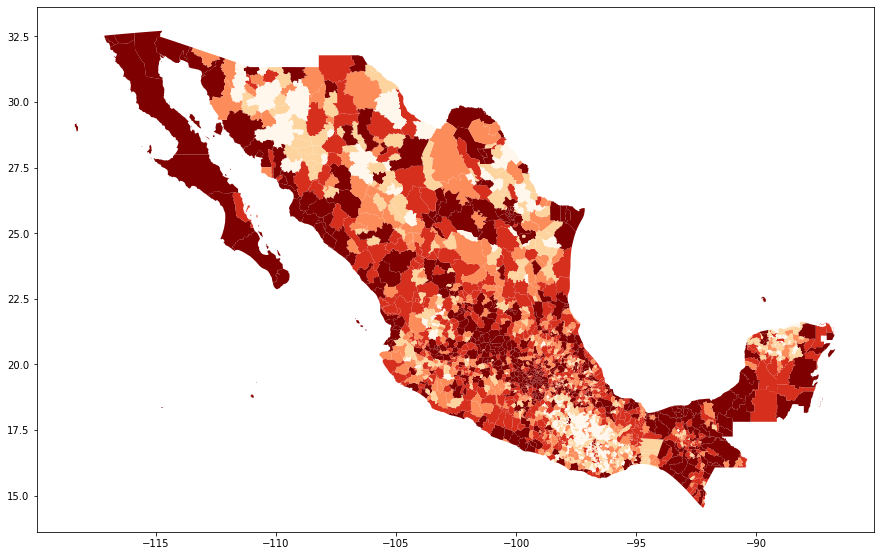

In [40]:
municipios.plot(column='pob2020', cmap='OrRd',figsize=(15, 10), scheme="quantiles")

La columna `municipio_cvegeo` nos permite unir los datos de COVID-19 a las geometrías (y los datos) de esta tabla de municipios. Pero recordemos que los datos de COVID en realidad son series de tiempo, entonces podemos empezar por hacer un mapa para una fecha específica, digamos la más reciente disponible.

Lo primero que vamos a hacer es extraer sólo la última fecha de los datos que ya tenemos aplanados (recuerden que estos sólo van a ser para algún estado). Esto quiere decir un mapa con los casos que reportaron en el último día, no los casos acumulados.

In [39]:
ultima_fecha = aplanados.loc[aplanados['FECHA_INGRESO'] == aplanados['FECHA_INGRESO'].max()]
ultima_fecha.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,INDIGENA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRAS_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,CLAVE_MUNICIPIO_RES,CLAVE_ENTIDAD_RES,INTUBADO_BIN,NEUMONIA_BIN,EMBARAZO_BIN,HABLA_LENGUA_INDIG_BIN,INDIGENA_BIN,DIABETES_BIN,EPOC_BIN,ASMA_BIN,INMUSUPR_BIN,HIPERTENSION_BIN,OTRAS_COM_BIN,CARDIOVASCULAR_BIN,OBESIDAD_BIN,RENAL_CRONICA_BIN,TABAQUISMO_BIN,OTRO_CASO_BIN,TOMA_MUESTRA_LAB_BIN,TOMA_MUESTRA_ANTIGENO_BIN,MIGRANTE_BIN,UCI_BIN,DEFUNCION,AÑO_INGRESO,MES_INGRESO,DIA_SEMANA_INGRESO,SEMANA_AÑO_INGRESO,DIA_MES_INGRESO,DIA_AÑO_INGRESO
FECHA_INGRESO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-13,2021-07-13,730128,2,3,TABASCO,2,TABASCO,TABASCO,CENTRO,AMBULATORIO,2021-07-13,2021-07-12,NaT,97,2,48,1,97,2,2,2,2,2,2,2,2,2,2,2,2,2,1,RESULTADO PENDIENTE,2,97,CASO SOSPECHOSO,99,MÃ©xico,97,97,27004,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2021,7,1,28,13,194
2021-07-13,2021-07-13,e408db,2,3,TABASCO,1,MÉXICO,TABASCO,CENTRO,AMBULATORIO,2021-07-13,2021-07-13,NaT,97,2,47,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,RESULTADO PENDIENTE,2,97,CASO SOSPECHOSO,99,MÃ©xico,97,97,27004,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2021,7,1,28,13,194
2021-07-13,2021-07-13,68d46d,1,12,TABASCO,1,TABASCO,TABASCO,CENTRO,AMBULATORIO,2021-07-13,2021-07-06,NaT,97,2,24,1,2,1,2,2,2,2,2,2,2,2,2,2,2,1,1,RESULTADO PENDIENTE,2,97,CASO SOSPECHOSO,99,MÃ©xico,97,97,27004,27,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2021,7,1,28,13,194
2021-07-13,2021-07-13,7b4351,2,12,TABASCO,2,TABASCO,TABASCO,TENOSIQUE,AMBULATORIO,2021-07-13,2021-07-06,NaT,97,2,37,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,1,RESULTADO PENDIENTE,2,97,CASO SOSPECHOSO,99,MÃ©xico,97,97,27017,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2021,7,1,28,13,194
2021-07-13,2021-07-13,7a2050,2,12,TABASCO,2,TABASCO,TABASCO,TENOSIQUE,AMBULATORIO,2021-07-13,2021-07-07,NaT,97,2,30,1,97,2,2,2,2,2,2,2,2,2,2,2,2,1,1,RESULTADO PENDIENTE,2,97,CASO SOSPECHOSO,99,MÃ©xico,97,97,27017,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2021,7,1,28,13,194


Ya con esta tabla, podemos hacer un agregado por municipio para ver el total de casos en cada uno.

In [42]:
por_municipio = (ultima_fecha
                 .groupby(['CLAVE_MUNICIPIO_RES', 'MUNICIPIO_RES'])['ID_REGISTRO']
                 .size()
                 .reset_index()
                 .rename({"ID_REGISTRO": "Nuevos Casos"}, axis=1)
                 )
por_municipio

,CLAVE_MUNICIPIO_RES,MUNICIPIO_RES,Nuevos Casos
0,27004,CENTRO,3
1,27017,TENOSIQUE,2


Tenemos la lista de los municipios *que tuvieron* casos en la fecha que estamos analizando, para hacer un mapa necesitamos unir estos datos a la geometría de los municipios.

Primero vamos a seleccionar, a partir del GeoDataFrame que ya tenemos sólo los municipios de la entidad que estamos analizando. A partir de eso podemos realizar una unión via la clave del municipio, sólo tenemos que tener cuiaddo de utilizar el tipo de unión adecuada para no dejar fuera los municipios sin casos.

In [43]:
tabasco = municipios[municipios.entidad_cvegeo == '27']
casos_municipio = (tabasco
                   .merge(por_municipio, left_on='municipio_cvegeo', right_on='CLAVE_MUNICIPIO_RES', how='left') # Unimos con los municipios
                   .drop(columns=['CLAVE_MUNICIPIO_RES', 'MUNICIPIO_RES']) # eliminamos dos columnas que ya no vamosd a usar
                   .fillna(0) # Los municipios sin casos deben tener 0 en lugar de NaN
                   )
casos_municipio

,id,oid,municipio_cvegeo,municipio,pob2020,pob_0a4,pob_0a9,pob60ym,entidad_cvegeo,geometry,Nuevos Casos
0,1962,1974,27001,Balancán,64346,5699,11796,8043,27,"POLYGON ((-91.32829 18.06280, -91.33071 18.062...",0.0
1,1963,1975,27002,Cárdenas,276096,26576,54102,26808,27,"POLYGON ((-93.51199 18.38490, -93.51334 18.384...",0.0
2,1964,1971,27003,Centla,117902,11937,23980,11887,27,"POLYGON ((-92.33158 18.46030, -92.33734 18.457...",0.0
3,1965,1949,27004,Centro,739611,59062,119062,72126,27,"POLYGON ((-92.61030 18.06882, -92.60736 18.078...",3.0
4,1966,1950,27005,Comalcalco,217559,19903,40132,22570,27,"POLYGON ((-93.29372 18.38339, -93.29290 18.383...",0.0
5,1967,1881,27006,Cunduacán,148165,14600,29376,14343,27,"POLYGON ((-93.31771 18.19660, -93.31538 18.197...",0.0
6,1968,1938,27007,Emiliano Zapata,32992,2874,5721,4051,27,"POLYGON ((-91.73869 17.93618, -91.73954 17.935...",0.0
7,1969,1976,27008,Huimanguillo,200660,19986,40789,19268,27,"POLYGON ((-93.29824 17.94736, -93.30048 17.946...",0.0
8,1970,1993,27009,Jalapa,41267,3334,6807,5154,27,"POLYGON ((-92.71435 17.90726, -92.71746 17.911...",0.0
9,1971,1941,27010,Jalpa de Méndez,94252,9078,18070,9458,27,"POLYGON ((-93.00029 18.40313, -93.00290 18.403...",0.0


Con esta base ya podemos hacer un mapa, para havcerlo más interesante en este caso vamos a usar [folium](http://python-visualization.github.io/folium/) para hacer un mapa interactivo.

In [67]:
m = folium.Map(location=[17.8917015, -92.8174020], zoom_start=9) # Creamos la instancia de folium
folium.Choropleth( # Instanciamos un mapa de coropletas
    geo_data=casos_municipio, # Pasamos la geometría de los municipios
    data=casos_municipio[["municipio_cvegeo", "Nuevos Casos"]], # Las variables que vamos a usar en el mapa
    columns=["municipio_cvegeo", "Nuevos Casos"], # La primera columna une geometrías y datos, la segunda es la variable que vamos a mapear
    key_on="feature.properties.municipio_cvegeo", # Cómo se unen los datos
    bins=4, # Cuántos intervalos iguales queremos en la clasificación 
    fill_color="OrRd", # La escala de colores
    fill_opacity=0.7, # Opacidad del relleno
    line_opacity=0.2, # opacidad de la línea
    legend_name="Nuevos Casos",
).add_to(m)
m

Ya hicimos un mapa para una fecha específica, ahora podemos hacer un mapa igual pero del total de casos acumulados. Lo primero que tenemos que hacer es calcular los acumulados totales para cada municipio, esto se hace agrpando los datos por municipio y calculando el tamaño de cada grupo.

In [90]:
acumulados_municipio = (aplanados
                        .groupby(['CLAVE_MUNICIPIO_RES', 'MUNICIPIO_RES'])['ID_REGISTRO']
                        .size()
                        .reset_index()
                        .rename({'ID_REGISTRO': 'Casos Acumulados'}, axis=1)
                        )
acumulados_municipio

,CLAVE_MUNICIPIO_RES,MUNICIPIO_RES,Casos Acumulados
0,27001,BALANCÁN,3334
1,27002,CÁRDENAS,38740
2,27003,CENTLA,4388
3,27004,CENTRO,131366
4,27005,COMALCALCO,9961
5,27006,CUNDUACÁN,8522
6,27007,EMILIANO ZAPATA,2810
7,27008,HUIMANGUILLO,7796
8,27009,JALAPA,3621
9,27010,JALPA DE MÉNDEZ,8985


Unimos a las geometrías de municipios y hacemos un mapa

In [93]:
acumulados_municipio = (tabasco
                        .merge(acumulados_municipio, left_on='municipio_cvegeo', right_on='CLAVE_MUNICIPIO_RES', how='left')
                        .drop(columns=['CLAVE_MUNICIPIO_RES', 'MUNICIPIO_RES'])
                        .fillna(0)
                        )
m = folium.Map(location=[17.8917015, -92.8174020], zoom_start=10) # Creamos la instancia de folium
folium.Choropleth( # Instanciamos un mapa de coropletas
    geo_data=acumulados_municipio, # Pasamos la geometría de los municipios
    data=acumulados_municipio[["municipio_cvegeo", "Casos Acumulados"]], # Las variables que vamos a usar en el mapa
    columns=["municipio_cvegeo", "Casos Acumulados"], # La primera columna une geometrías y datos, la segunda es la variable que vamos a mapear
    key_on="feature.properties.municipio_cvegeo", # Cómo se unen los datos
    bins=6, # Cuántos intervalos iguales queremos en la clasificación 
    fill_color="OrRd", # La escala de colores
    fill_opacity=0.7, # Opacidad del relleno
    line_opacity=0.2, # opacidad de la línea
    legend_name="Casos Acumulados",
).add_to(m)
m

Una forma más adecuada de representar estos mismos datos es utilizando la cantidad de casos por cada 100,000 habitantes, para no sesgar el mapa por la población que vive en cada municipio. Los datos de población vienen en la capa de municipios, entonces calcular la tasa es muy sencillo

In [82]:
acumulados_municipio['Tasa x 100,000 habitantes'] = (acumulados_municipio['Casos Acumulados']/acumulados_municipio['pob2020']) * 100000
m = folium.Map(location=[17.8917015, -92.8174020], zoom_start=10) # Creamos la instancia de folium
folium.Choropleth( # Instanciamos un mapa de coropletas
    geo_data=acumulados_municipio, # Pasamos la geometría de los municipios
    data=acumulados_municipio[["municipio_cvegeo", "Tasa x 100,000 habitantes"]], # Las variables que vamos a usar en el mapa
    columns=["municipio_cvegeo", "Tasa x 100,000 habitantes"], # La primera columna une geometrías y datos, la segunda es la variable que vamos a mapear
    key_on="feature.properties.municipio_cvegeo", # Cómo se unen los datos
    bins=6, # Cuántos intervalos iguales queremos en la clasificación 
    fill_color="OrRd", # La escala de colores
    fill_opacity=0.7, # Opacidad del relleno
    line_opacity=0.2, # opacidad de la línea
    legend_name="Tasa x 100,000 habitantes",
).add_to(m)
m

Es muy claro que son dos mapas diferentes. Para apreciarlo mejor, podemos ponerlos juntos como capas de un mismo mapa de folium y agragar un *control* para cambiar las capas

In [83]:
m = folium.Map(location=[17.8917015, -92.8174020], zoom_start=11) # Creamos la instancia de folium
# Agregamos la primera capa
folium.Choropleth( # Instanciamos un mapa de coropletas
    geo_data=acumulados_municipio, # Pasamos la geometría de los municipios
    name="Tasa x 100,000 habitantes", # Un nombre para distinguirlas en el control
    data=acumulados_municipio[["municipio_cvegeo", "Tasa x 100,000 habitantes"]], # Las variables que vamos a usar en el mapa
    columns=["municipio_cvegeo", "Tasa x 100,000 habitantes"], # La primera columna une geometrías y datos, la segunda es la variable que vamos a mapear
    key_on="feature.properties.municipio_cvegeo", # Cómo se unen los datos
    bins=6, # Cuántos intervalos iguales queremos en la clasificación 
    fill_color="OrRd", # La escala de colores
    fill_opacity=0.7, # Opacidad del relleno
    line_opacity=0.2, # opacidad de la línea
    legend_name="Tasa x 100,000 habitantes",
).add_to(m)
# Agregamos la segunda
folium.Choropleth( # Instanciamos un mapa de coropletas
    geo_data=acumulados_municipio, # Pasamos la geometría de los municipios
    name="Casos Acumulados", # Un nombre para distinguirlas en el control
    data=acumulados_municipio[["municipio_cvegeo", "Casos Acumulados"]], # Las variables que vamos a usar en el mapa
    columns=["municipio_cvegeo", "Casos Acumulados"], # La primera columna une geometrías y datos, la segunda es la variable que vamos a mapear
    key_on="feature.properties.municipio_cvegeo", # Cómo se unen los datos
    bins=6, # Cuántos intervalos iguales queremos en la clasificación 
    fill_color="OrRd", # La escala de colores
    fill_opacity=0.7, # Opacidad del relleno
    line_opacity=0.2, # opacidad de la línea
    legend_name="Casos Acumulados",
).add_to(m)
# Agregamos un control para cambiar de capas
folium.LayerControl().add_to(m)
m